# Imports 

In [96]:
%matplotlib widget
import numpy as np
import tensorflow as tf
from tensorflow import keras

import mne

from matplotlib import pyplot as plt

from tqdm.autonotebook import tqdm

# Load MNIST Dataset

In [97]:
mnist = keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
# x_train = x_train[..., 5:-5]
x_train, x_test = x_train / 255.0, x_test / 255.0

TRAIN_WIDTH = x_train.shape[-1]
N_CHANNELS = 28
N_CLASSES = 10

In [98]:
labels_int = np.arange(N_CLASSES)
labels = labels_int.astype(str)
labels, labels_int

(array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype='<U21'),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))

In [99]:
x_train.shape, x_test.shape

((60000, 28, 28), (10000, 28, 28))

Text(0.5, 1.0, '5')

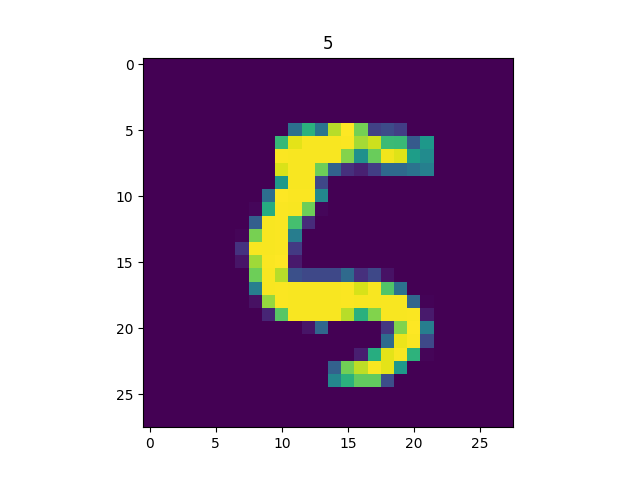

In [102]:
dig_idx = 2000


plt.figure()
plt.imshow(x_train[dig_idx])
plt.title(y_train[dig_idx])

## Prepend Baseline

In [103]:
x_train = np.concatenate([np.zeros_like(x_train), 
                          x_train], 
                         axis=-1)

Text(0.5, 1.0, '7')

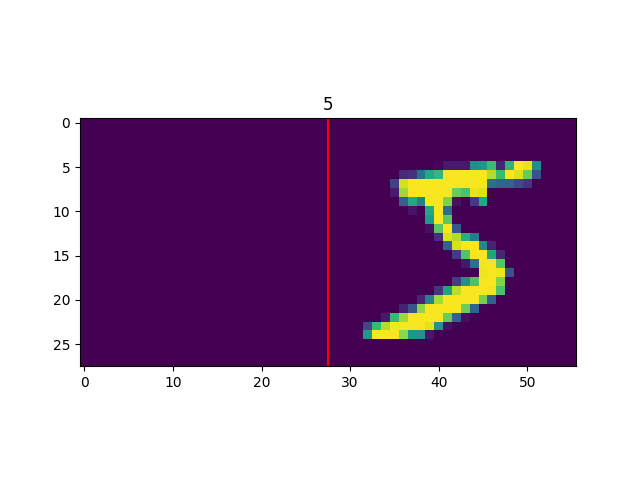

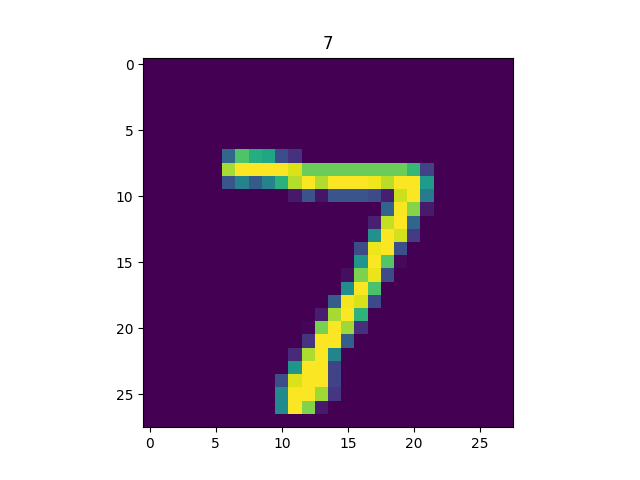

In [104]:
plt.figure()
plt.imshow(x_train[0])
plt.title(y_train[0])
plt.axvline(TRAIN_WIDTH-0.5, color='r')

plt.figure()
plt.imshow(x_test[0])
plt.title(y_test[0])

# Mimic EMG envelope channels

In [105]:
emg_train = x_train.transpose(0,2,1).reshape(-1, N_CHANNELS).T
emg_test = x_test.transpose(0,2,1).reshape(-1, N_CHANNELS).T
'train', emg_train.shape, 'test', emg_test.shape

('train', (28, 3360000), 'test', (28, 280000))

Text(0.5, 1.0, 'EMG channels')

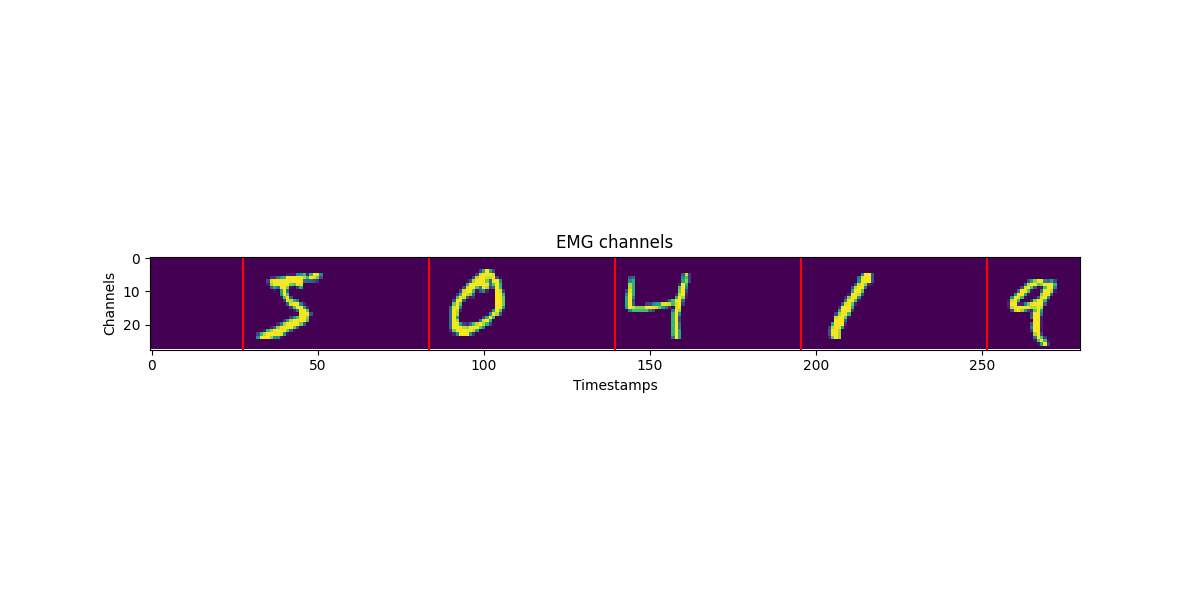

In [106]:
plt.figure(figsize=(12,6))
plt.imshow(emg_train[:, :10*TRAIN_WIDTH])
plt.vlines([TRAIN_WIDTH-0.5 + TRAIN_WIDTH*i*2 for i in range(5)], *plt.ylim(), color='r')
plt.xlabel('Timestamps')
plt.ylabel('Channels')
plt.title('EMG channels')

# Add some noise

In [107]:

emg_train += np.random.random(size = (emg_train.shape)) * 0.33
emg_test  += np.random.random(size = (emg_test.shape)) * 0.33

Text(0.5, 1.0, 'Mimicking EMG envelope with noise')

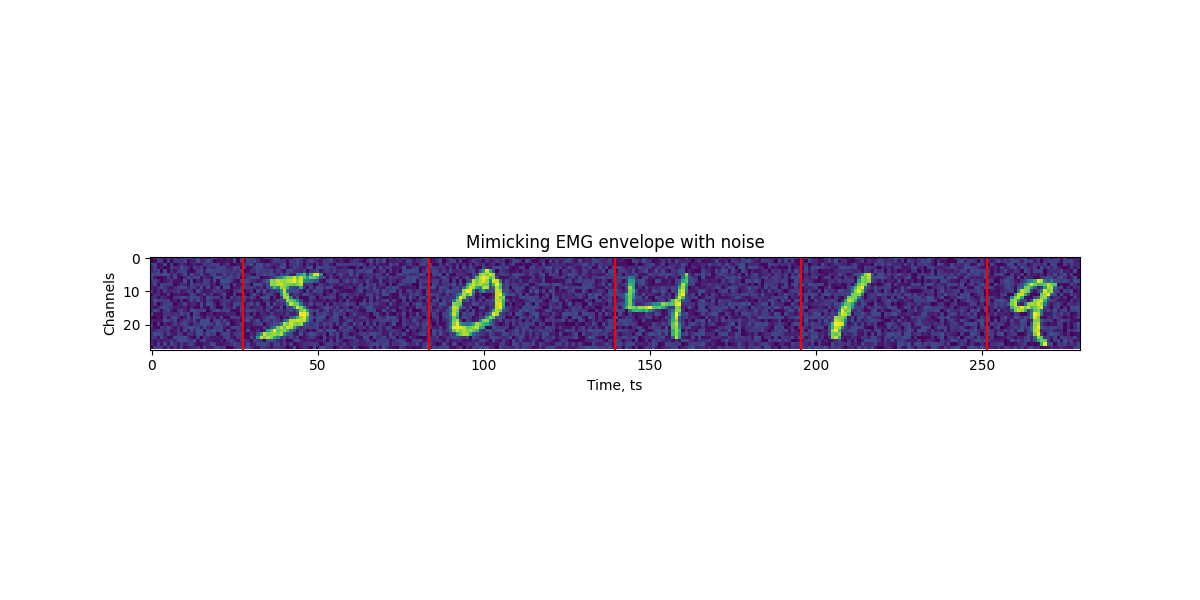

In [108]:
plt.figure(figsize=(12,6))
plt.imshow(emg_train[:, :10*TRAIN_WIDTH])
plt.vlines([TRAIN_WIDTH-0.5 + TRAIN_WIDTH*i*2 for i in range(5)], *plt.ylim(), color='r')
plt.xlabel('Time, ts')
plt.ylabel('Channels')
plt.title('Mimicking EMG envelope with noise')

Text(0.5, 1.0, 'Mimicking TEST EMG envelope with noise')

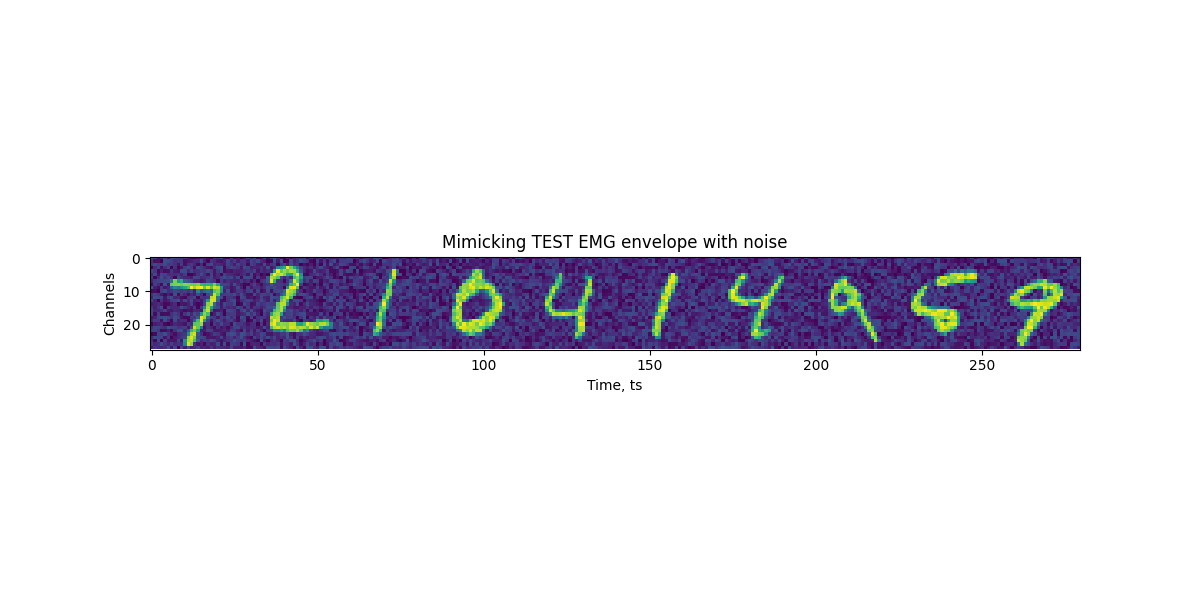

In [111]:
plt.figure(figsize=(12,6))
plt.imshow(emg_test[:, :10*TRAIN_WIDTH])
# plt.vlines([TRAIN_WIDTH-0.5 + TRAIN_WIDTH*i*2 for i in range(5)], *plt.ylim(), color='r')
plt.xlabel('Time, ts')
plt.ylabel('Channels')
plt.title('Mimicking TEST EMG envelope with noise')

# Create raw MNE object

In [112]:
raw_test  = mne.io.RawArray(emg_test, mne.create_info(list(np.arange(N_CHANNELS).astype(str)), sfreq=28, ch_types='emg'))
raw_train = mne.io.RawArray(emg_train, mne.create_info(list(np.arange(N_CHANNELS).astype(str)), sfreq=28, ch_types='emg'))

Creating RawArray with float64 data, n_channels=28, n_times=280000
    Range : 0 ... 279999 =      0.000 ...  9999.964 secs
Ready.
Creating RawArray with float64 data, n_channels=28, n_times=3360000
    Range : 0 ... 3359999 =      0.000 ... 119999.964 secs
Ready.



## Create event data

In [113]:
events_train = np.stack([[TRAIN_WIDTH + TRAIN_WIDTH*2*i for i in range(len(x_train))], 
                         np.zeros(len(x_train), 
                                  dtype=int), y_train], axis=1)
events_train

array([[     28,       0,       5],
       [     84,       0,       0],
       [    140,       0,       4],
       ...,
       [3359860,       0,       5],
       [3359916,       0,       6],
       [3359972,       0,       8]])

## Visualize

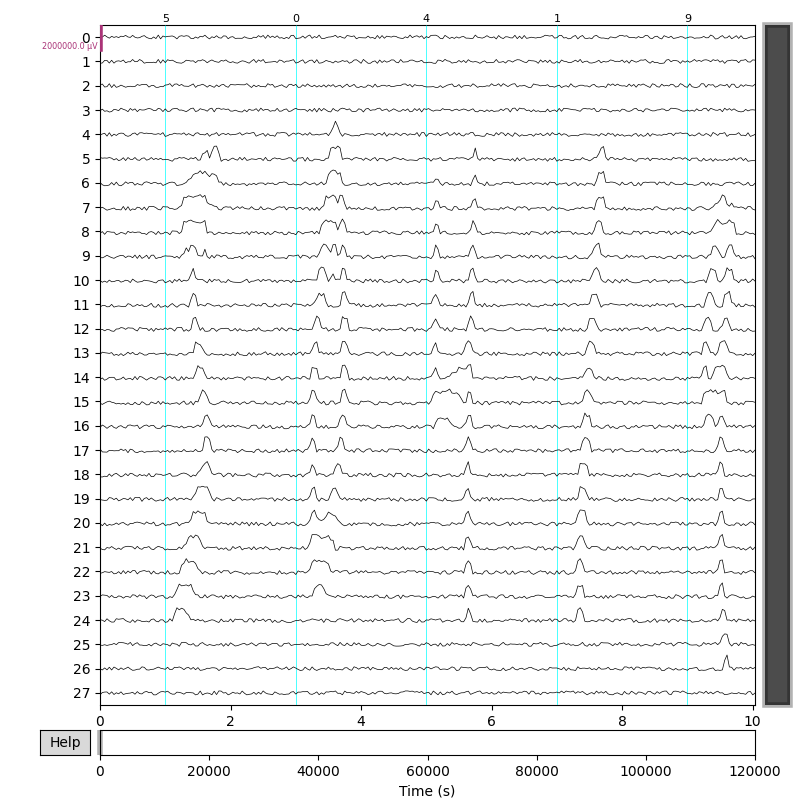

In [114]:
raw_train.plot(scalings={'emg':1}, 
               n_channels=N_CHANNELS, 
               events=events_train);

plt.gcf().set_size_inches(12,6)

plt.tight_layout()

## NO-GO Event

NO-GO selection strategy 
- take random events from the train set - assume random events result in random outputs
- derive from inference, e.g. NO_GO == below threshold activation
- make explicit NO-GO event in the data acquisition protocol, e.g. from baseline
- construct NO-GO events from the data

In [16]:
%matplotlib widget

Text(0.5, 1.0, 'Label representation')

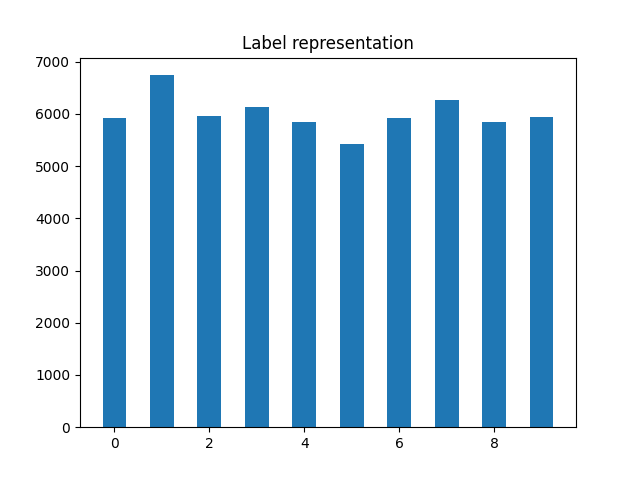

In [115]:
plt.figure()
plt.hist(y_train, bins=np.linspace(-0.25, 9.25, 20))
plt.title('Label representation')

In [116]:
# assume homogeneous label distribution

n_nogo_labels = len(y_train)//N_CLASSES
n_nogo_labels

6000

### Random Strategy (you can try it on your own)

In [19]:
nogo_timestamps = np.random.choice(np.arange(len(raw_train.times)), n_nogo_labels)
events_nogo = np.stack([nogo_timestamps, np.zeros_like(nogo_timestamps), np.ones_like(nogo_timestamps)*10], axis=1)
events_nogo

array([[2136004,       0,      10],
       [2046716,       0,      10],
       [ 153330,       0,      10],
       ...,
       [3343325,       0,      10],
       [1081176,       0,      10],
       [1530397,       0,      10]])

In [20]:
## Inject NOGO events

# concatenation with sorting on the go
events_train_w_nogo_random = np.array(sorted(np.concatenate([events_train, events_nogo], 
                                                             axis=0), 
                                              key=lambda row: row[0]))


## Construction of NO-GO events strategy (see supplementary presentation)

How many timestamps to slice? 
SampleWidth * Num_NOGO_events = TRAIN_WIDTH*6000 = 

In [117]:
TRAIN_WIDTH*6000

168000

In [118]:
np.random.choice(np.arange(len(raw_train.times)), size=TRAIN_WIDTH*6000, replace=False)

array([2864207, 2397374, 2066030, ..., 2585061, 2034549, 2742291])

In [119]:
raw_train._data[:,np.random.choice(np.arange(len(raw_train.times)), size=TRAIN_WIDTH*6000, replace=False)].shape

(28, 168000)

In [120]:
raw_train._data[:,np.random.choice(np.arange(len(raw_train.times)), size=TRAIN_WIDTH*6000, replace=False)].reshape(28, TRAIN_WIDTH, -1).shape

(28, 28, 6000)

(28, 336000)

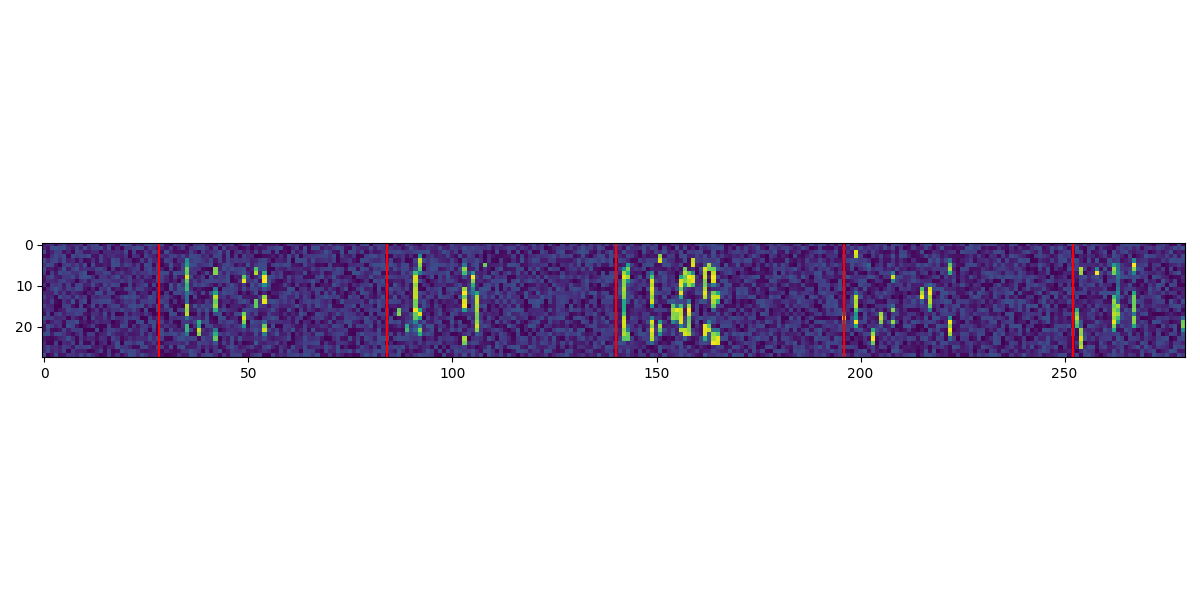

In [121]:
nogo_constructed = raw_train._data[:,np.random.choice(np.arange(len(raw_train.times)), size=TRAIN_WIDTH*6000, replace=False)].reshape(28, -1, TRAIN_WIDTH)

emg_nogo = np.concatenate([np.zeros_like(nogo_constructed) + np.random.random(size = (nogo_constructed.shape)) * 0.33, nogo_constructed], axis=-1).reshape(28, -1)

plt.figure(figsize=(12, 6))
plt.imshow(emg_nogo[:, :10*TRAIN_WIDTH])
plt.vlines([TRAIN_WIDTH + TRAIN_WIDTH*2*i for i in range(5)], *plt.ylim(), color='r')
plt.tight_layout()

emg_nogo.shape

In [122]:
emg_train_w_nogo = np.concatenate([emg_train, emg_nogo], axis=-1)
emg_train_w_nogo.shape

(28, 3696000)

In [123]:
raw_train_w_nogo  = mne.io.RawArray(emg_train_w_nogo, mne.create_info(list(np.arange(N_CHANNELS).astype(str)), sfreq=28, ch_types='emg'))

Creating RawArray with float64 data, n_channels=28, n_times=3696000
    Range : 0 ... 3695999 =      0.000 ... 131999.964 secs
Ready.


## Visualize w nogo


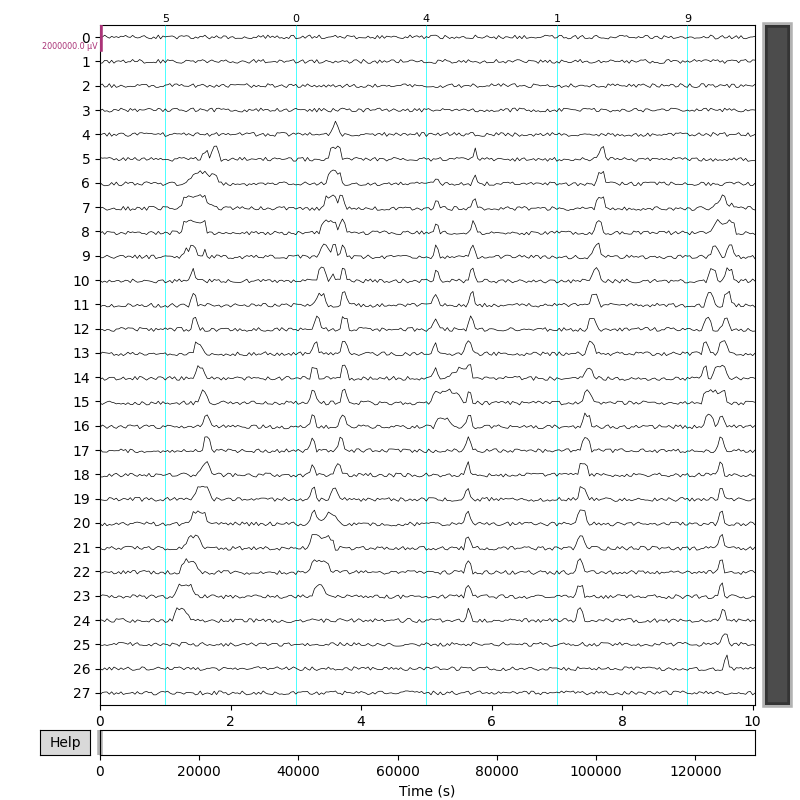

In [124]:
raw_train_w_nogo.plot(scalings={'emg':1},
                       n_channels=N_CHANNELS, 
                       events=events_train);

plt.gcf().set_size_inches(12,6)

plt.tight_layout()

In [125]:
events_train

array([[     28,       0,       5],
       [     84,       0,       0],
       [    140,       0,       4],
       ...,
       [3359860,       0,       5],
       [3359916,       0,       6],
       [3359972,       0,       8]])

In [126]:
events_nogo = events_train[:n_nogo_labels].copy()
events_nogo[:, 0] += emg_train.shape[-1]
events_nogo[:, -1] = 10
events_nogo

array([[3360028,       0,      10],
       [3360084,       0,      10],
       [3360140,       0,      10],
       ...,
       [3695860,       0,      10],
       [3695916,       0,      10],
       [3695972,       0,      10]])

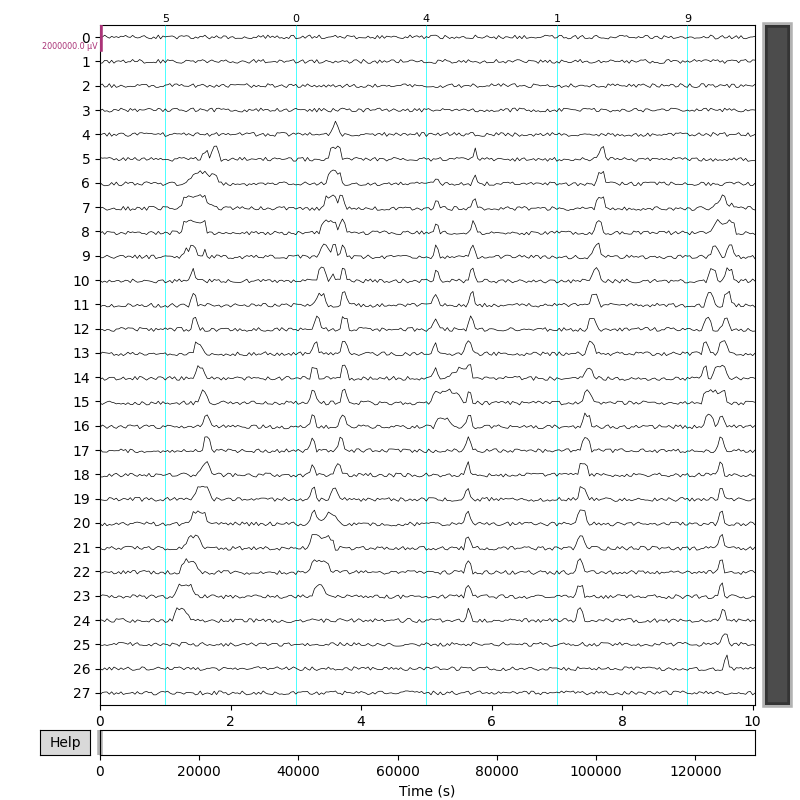

In [127]:
events_train_w_nogo = np.concatenate([events_train, events_nogo], axis=0)

raw_train_w_nogo.plot(scalings={'emg':1},
                       n_channels=N_CHANNELS, 
                       events=events_train_w_nogo);

plt.gcf().set_size_inches(12,6)

plt.tight_layout()

# Epoch analysis

In [128]:
sfreq = raw_train_w_nogo.info['sfreq']
epochs = mne.Epochs(raw_train_w_nogo,
                    events = events_train_w_nogo, 
                    tmin=-TRAIN_WIDTH/sfreq, tmax=TRAIN_WIDTH/sfreq, 
                    preload=True)

Not setting metadata
66000 matching events found
Setting baseline interval to [-1.0, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 66000 events and 57 original time points ...
1 bad epochs dropped


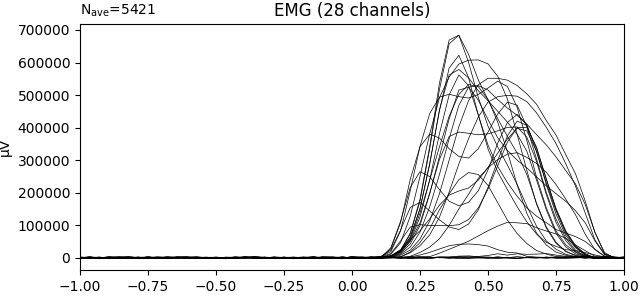

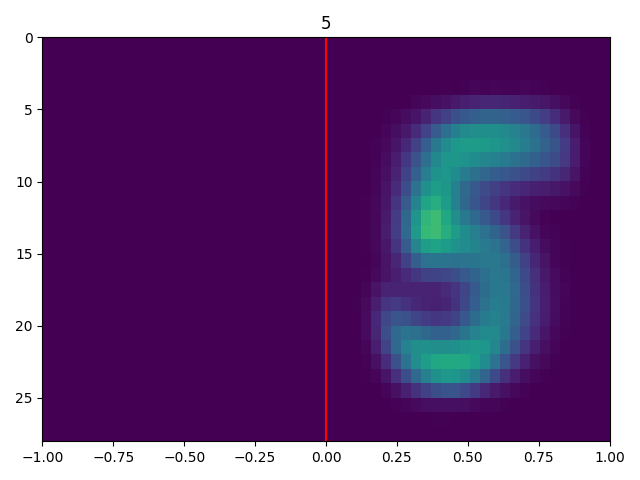

In [133]:
vis_label = "5"

av = epochs[vis_label].average(picks=['emg']);
av.plot();
plt.axvline(0, color='r')
plt.tight_layout()

plt.figure()
plt.imshow(av.data, vmin=0, vmax=1, extent=[av.times.min(), av.times.max(), 28, 0], aspect='auto')
plt.title(vis_label)
plt.axvline(0, color='r')
plt.tight_layout()

# Visualize manifold

In [135]:
epochs._data.shape

(65999, 28, 57)

In [136]:
EPOCH_SIZE = len(epochs.times)

In [137]:
%%time

decimation = 10 # 10 for faster computing
X = epochs._data.reshape(len(epochs), -1)[epochs.events[:, -1]<10][::decimation] # taking all 10 will result in spoiling the resulting figure
y = epochs[epochs.events[:, -1]<10][::decimation].events[:,-1]

X.shape, y.shape

from sklearn.manifold import TSNE
tsne = TSNE(init='pca', verbose=10)
tv = tsne.fit_transform(X)

/Users/mike/anaconda3/envs/2022_neurotech_course/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 6000 samples in 0.032s...
[t-SNE] Computed neighbors for 6000 samples in 0.981s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6000
[t-SNE] Computed conditional probabilities for sample 2000 / 6000
[t-SNE] Computed conditional probabilities for sample 3000 / 6000
[t-SNE] Computed conditional probabilities for sample 4000 / 6000
[t-SNE] Computed conditional probabilities for sample 5000 / 6000
[t-SNE] Computed conditional probabilities for sample 6000 / 6000
[t-SNE] Mean sigma: 2.105707
[t-SNE] Computed conditional probabilities in 0.242s


/Users/mike/anaconda3/envs/2022_neurotech_course/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] Iteration 50: error = 84.2238312, gradient norm = 0.0030253 (50 iterations in 1.230s)
[t-SNE] Iteration 100: error = 84.8822556, gradient norm = 0.0001165 (50 iterations in 1.018s)
[t-SNE] Iteration 150: error = 84.8863373, gradient norm = 0.0000639 (50 iterations in 1.010s)
[t-SNE] Iteration 200: error = 84.8863449, gradient norm = 0.0000584 (50 iterations in 0.981s)
[t-SNE] Iteration 250: error = 84.8861618, gradient norm = 0.0000593 (50 iterations in 0.964s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 84.886162
[t-SNE] Iteration 300: error = 2.4926267, gradient norm = 0.0011127 (50 iterations in 0.933s)
[t-SNE] Iteration 350: error = 2.1347170, gradient norm = 0.0004644 (50 iterations in 0.922s)
[t-SNE] Iteration 400: error = 1.9785593, gradient norm = 0.0002767 (50 iterations in 0.955s)
[t-SNE] Iteration 450: error = 1.8887088, gradient norm = 0.0001898 (50 iterations in 0.947s)
[t-SNE] Iteration 500: error = 1.8311685, gradient norm = 0.0001459 (50 

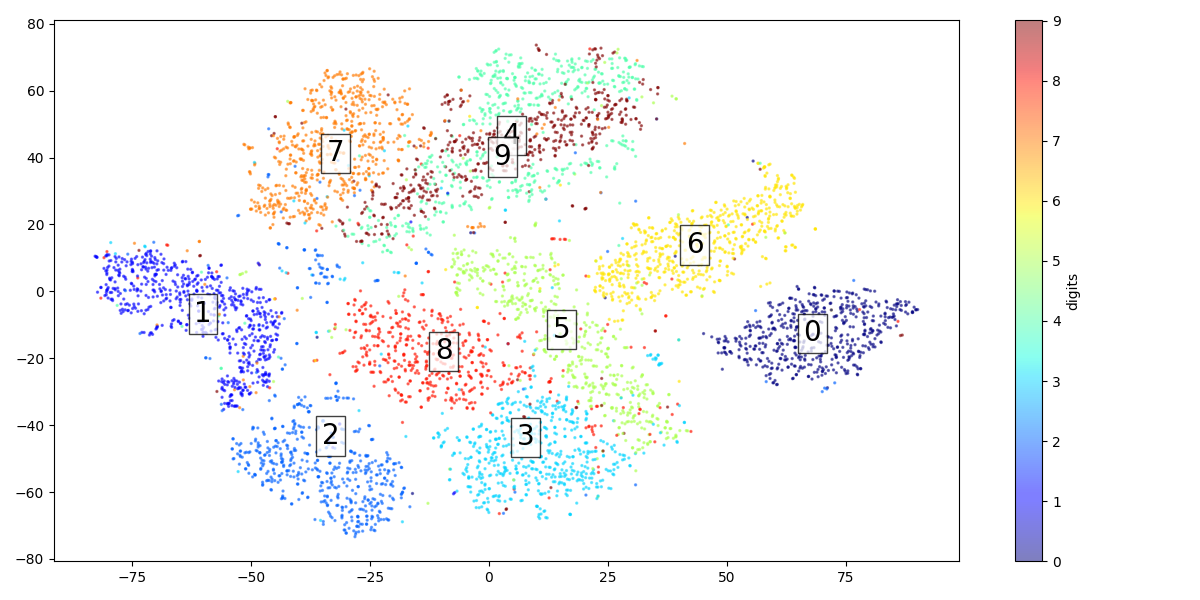

In [138]:
plt.figure(figsize=(12,6))
plt.scatter(*(tv.T), 
            c = y, 
            s=2, 
            alpha=0.5, 
            cmap='jet')

h = plt.colorbar(label='digits')

h.set_ticks(np.arange(10))

for l in np.unique(y):
    mask = y==l
    t = plt.text(*tv[mask].mean(axis=0), l, ha='center', va='center', fontsize=20)
    t.set_bbox(dict(facecolor='white', alpha=0.75, edgecolor='black'))

plt.tight_layout()


# Model construction

## Simple RNN

In [139]:
EPOCH_SHAPE[-1]

28

In [140]:
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Input, LSTM
from tensorflow.keras.utils import to_categorical, plot_model

N_HIDDEN = 50
EPOCH_SHAPE = epochs._data[0].T.shape # in keras time goes first
N_CLASSES = 11

model = Sequential()

model_input = x = Input(shape=[None, 
                               EPOCH_SHAPE[-1]], 
                        batch_size=None)

x = SimpleRNN(N_HIDDEN, 
             activation='relu',
             recurrent_regularizer=tf.keras.regularizers.L1L2(l1=1e-2, l2=1e-2),
             return_sequences=True)(x)

# see comments in supplementary
# x = SimpleRNN(N_HIDDEN, 
#              activation='relu',
#              recurrent_regularizer=tf.keras.regularizers.L1L2(l1=1e-2, l2=1e-2),
#              return_sequences=True)(x)

model_output = tf.keras.layers.TimeDistributed(Dense(units=N_CLASSES, 
                                                     activation='sigmoid'))(x)

model = tf.keras.Model(model_input, model_output)

model.summary(expand_nested=True)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None, 28)]        0         
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, None, 50)          3950      
                                                                 
 time_distributed_2 (TimeDis  (None, None, 11)         561       
 tributed)                                                       
                                                                 
Total params: 4,511
Trainable params: 4,511
Non-trainable params: 0
_________________________________________________________________


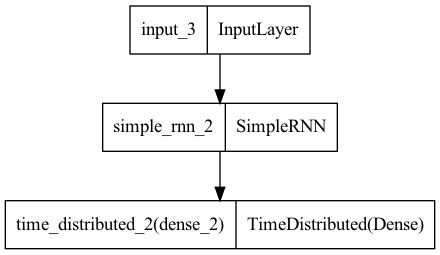

In [141]:
plot_model(model)

In [47]:
model.compile(loss='mse', 
              optimizer='adam',
              metrics=['accuracy'])

In [142]:
X = epochs._data.copy()
X = np.transpose(X, [0, 2, 1]) # because timestamps goes first for keras recurrent layers, batch.shape = (Batch_size, Timestamps, Channel1, Channel2, Channel3, ...)
y = to_categorical(epochs.events[:,-1])
y = np.repeat(y[:, np.newaxis, :], 
              axis=1,
              repeats=len(epochs.times))
y[:, epochs.times<0, :] = [[[0]*10+[1]]]

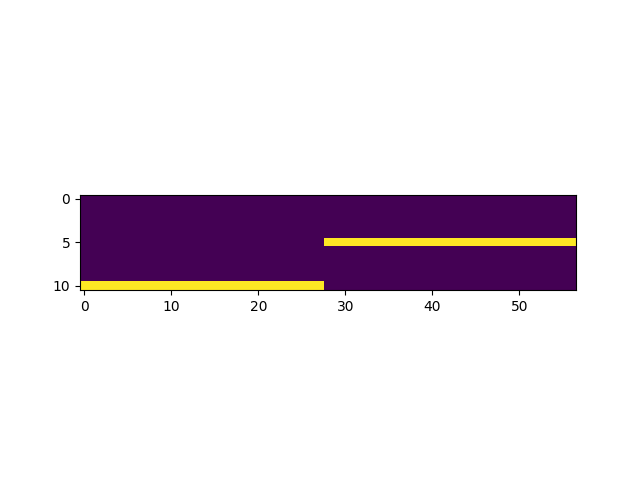

In [145]:
plt.figure()
plt.imshow(y[0].T)

In [146]:
from sklearn.model_selection import train_test_split


In [147]:
X_t, X_v, y_t, y_v = train_test_split(X, y, stratify=epochs.events[:,-1], test_size=0.1)

In [148]:
X_t.shape, X_v.shape

((59399, 57, 28), (6600, 57, 28))

In [51]:
%%time
model.fit(X_t, y_t, epochs=50, validation_data=(X_v, y_v))

Epoch 1/50
1857/1857 [==============================] - 19s 10ms/step - loss: 0.2310 - accuracy: 0.5628 - val_loss: 0.0556 - val_accuracy: 0.5999
Epoch 2/50
1857/1857 [==============================] - 17s 9ms/step - loss: 0.0551 - accuracy: 0.6095 - val_loss: 0.0547 - val_accuracy: 0.6171
Epoch 3/50
1857/1857 [==============================] - 18s 10ms/step - loss: 0.0544 - accuracy: 0.6203 - val_loss: 0.0542 - val_accuracy: 0.6235
Epoch 4/50
1857/1857 [==============================] - 17s 9ms/step - loss: 0.0540 - accuracy: 0.6249 - val_loss: 0.0539 - val_accuracy: 0.6266
Epoch 5/50
1857/1857 [==============================] - 17s 9ms/step - loss: 0.0538 - accuracy: 0.6276 - val_loss: 0.0538 - val_accuracy: 0.6285
Epoch 6/50
1857/1857 [==============================] - 17s 9ms/step - loss: 0.0537 - accuracy: 0.6294 - val_loss: 0.0536 - val_accuracy: 0.6299
Epoch 7/50
1857/1857 [==============================] - 17s 9ms/step - loss: 0.0536 - accuracy: 0.6307 - val_loss: 0.0535 - val_

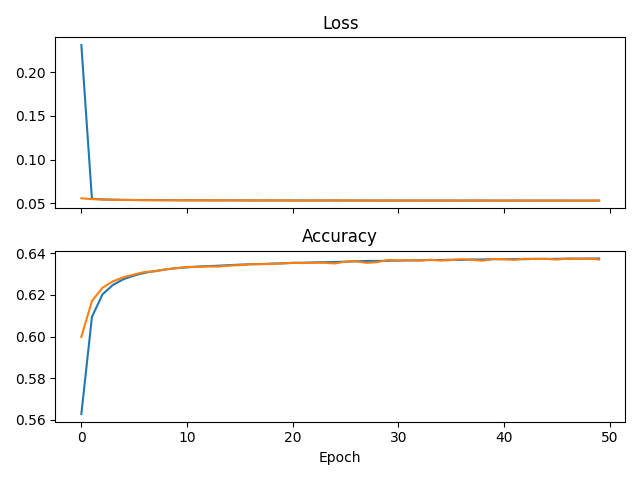

In [52]:
fig, axx = plt.subplots(2,1,sharex=True)
plt.sca(axx[0])
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('Loss')
plt.sca(axx[1])
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.tight_layout()

In [149]:
# model.save('model.h5')
model = keras.models.load_model('model.h5')

### Sanity check

Sample shape (1, 57, 28)
1/1 [==============================] - 0s 23ms/step


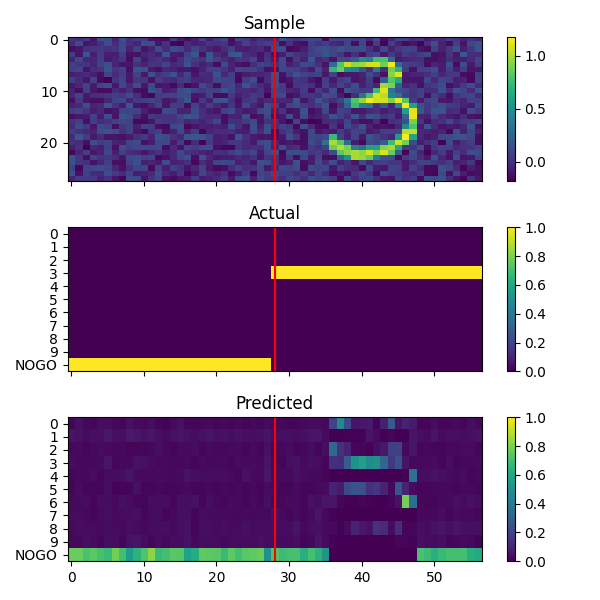

In [152]:
sample_of_interest = 50;
sample = np.transpose(epochs[sample_of_interest]._data, [0, 2, 1])
print('Sample shape', sample.shape)

activations = model.predict(sample)

fig, axx = plt.subplots(3, 1, figsize=(6,6), sharex=True)
plt.sca(axx[0])
plt.imshow(sample[0].T, aspect='auto')
plt.axvline(TRAIN_WIDTH, color='r')
plt.title('Sample')
plt.colorbar()

plt.sca(axx[1])
plt.imshow(y[sample_of_interest].T, aspect='auto')
plt.yticks(np.arange(11), list(range(10))+['NOGO'])
# plt.grid(True)
plt.axvline(TRAIN_WIDTH, color='r')
plt.title('Actual')
plt.colorbar()

plt.sca(axx[2])
plt.imshow(activations[0].T, aspect='auto', vmin=0, vmax=1)
plt.axvline(TRAIN_WIDTH, color='r')
# plt.grid(True)
plt.yticks(np.arange(11), list(range(10))+['NOGO'])
plt.colorbar()

plt.title('Predicted')
plt.tight_layout()

## Sliding inference

In [153]:
emg_test.shape

(28, 280000)

In [154]:
activations_keras = model.predict(emg_test.T[np.newaxis, ...])[0].T.astype(float)

1/1 [==============================] - 7s 7s/step


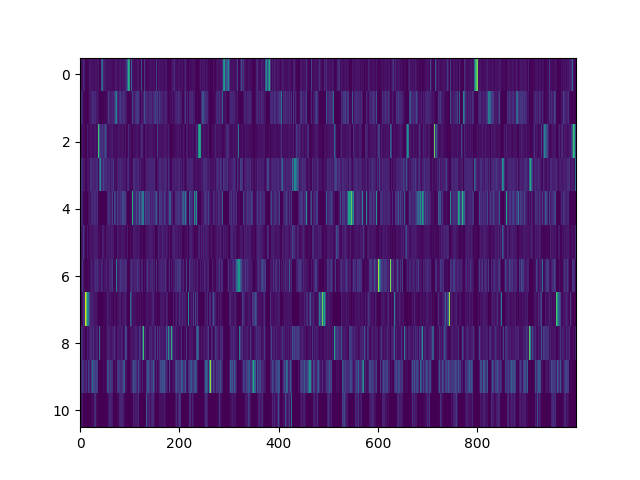

In [155]:
plt.figure()
plt.imshow(activations_keras[:, 0:1000], 
           aspect='auto', 
           interpolation="nearest", vmin=0, vmax=1)

In [157]:
y_test[:100]

array([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6,
       6, 5, 4, 0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2,
       3, 5, 1, 2, 4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 3, 7, 4,
       6, 4, 3, 0, 7, 0, 2, 9, 1, 7, 3, 2, 9, 7, 7, 6, 2, 7, 8, 4, 7, 3,
       6, 1, 3, 6, 9, 3, 1, 4, 1, 7, 6, 9], dtype=uint8)

In [59]:
activations_keras.shape

(11, 280000)

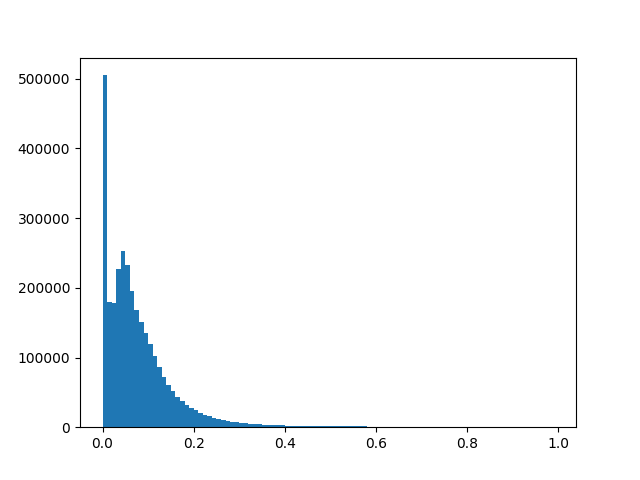

In [158]:
plt.figure()
plt.hist(activations_keras[activations_keras>0], bins=np.arange(0, 1, 0.01));
# plt.xscale('log')

In [61]:
activation_thresh = (activations_keras[activations_keras>0].mean(-1) + 3*activations_keras[activations_keras>0].std(-1)).mean()
activation_thresh

0.35476506205307984

Setting up low-pass filter at 2 Hz

FIR filter parameters
---------------------
Designing a one-pass, non-linear phase, causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper transition bandwidth: 2.00 Hz
- Filter length: 47 samples (1.679 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.9s finished


([<matplotlib.axis.YTick at 0x7fa8b68ad580>,
 [Text(0, 0, '0'),
  Text(0, 1, '1'),
  Text(0, 2, '2'),
  Text(0, 3, '3'),
  Text(0, 4, '4'),
  Text(0, 5, '5'),
  Text(0, 6, '6'),
  Text(0, 7, '7'),
  Text(0, 8, '8'),
  Text(0, 9, '9'),
  Text(0, 10, 'NOGO')])

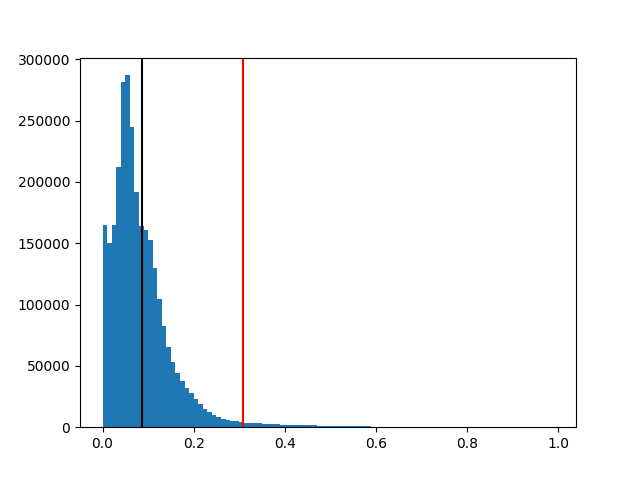

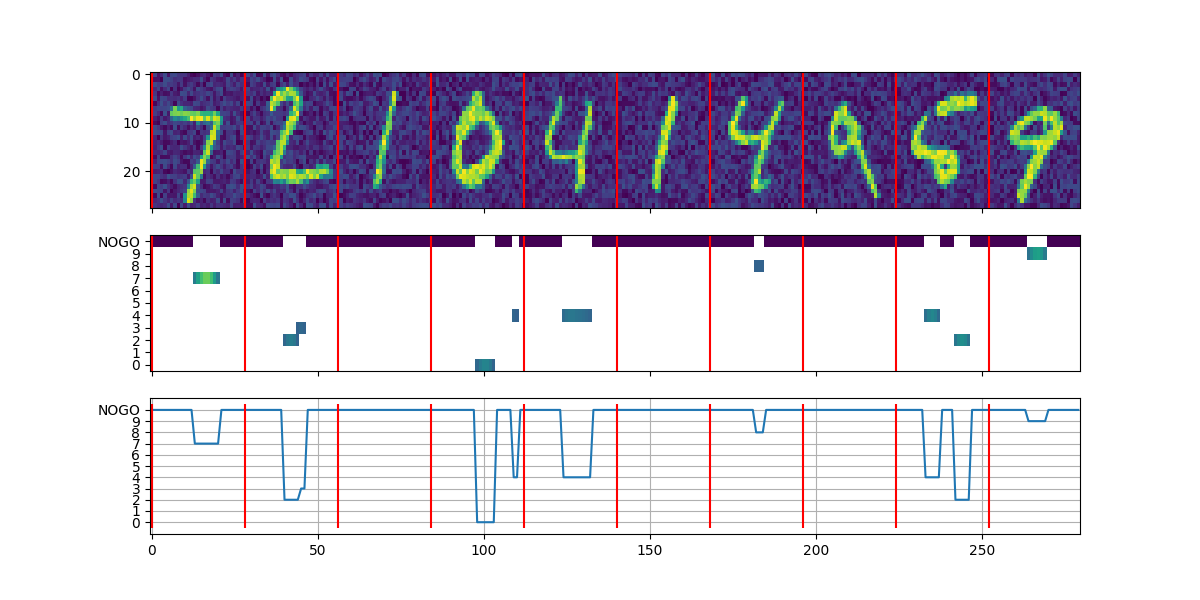

In [163]:
filtered_activations = activations_keras.copy()

mne.filter.filter_data(filtered_activations, sfreq=sfreq, l_freq=None, h_freq=2, copy=False, phase='minimum')

activation_thresh = (filtered_activations[filtered_activations>0].mean(-1) + 3*filtered_activations[filtered_activations>0].std(-1)).mean()
# activation_thresh = 0

plt.figure()
plt.hist(filtered_activations[filtered_activations>0], bins = np.arange(0, 1, 0.01))
plt.axvline(filtered_activations[filtered_activations>0].mean(-1), color='k')
plt.axvline(activation_thresh, color='r')

filtered_activations[filtered_activations<activation_thresh] = np.nan 
filtered_activations[-1, np.isnan(filtered_activations).all(0)] = 0

labels_predicted = np.nanargmax(filtered_activations, axis=0)

start_idx = 0
end_idx = start_idx+10

fig, axx = plt.subplots(3,1, sharex=True, figsize=(12,6))
plt.sca(axx[0])
plt.imshow(emg_test[:, start_idx*28:end_idx*28], aspect='auto')
plt.vlines(np.arange(end_idx-start_idx)*28, *plt.ylim(), color='r')

plt.sca(axx[1])
plt.imshow(filtered_activations[:, start_idx*28:end_idx*28], vmin=0, vmax=1, aspect='auto', interpolation='nearest')
plt.vlines(np.arange(end_idx-start_idx)*28, *plt.ylim(), color='r')
# plt.grid(True)
plt.gca().invert_yaxis()
plt.yticks(np.arange(11), list(range(10))+['NOGO'])

plt.sca(axx[2])
plt.plot(labels_predicted[start_idx*28:end_idx*28])
plt.vlines(np.arange(end_idx-start_idx)*28, *plt.ylim(), color='r')
plt.grid(True)
plt.yticks(np.arange(11), list(range(10))+['NOGO'])


# Numpy pseudocode for continuous inference

In [164]:
model.layers

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, 28)]        0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, None, 50)          3950      
                                                                 
 time_distributed_1 (TimeDis  (None, None, 11)         561       
 tributed)                                                       
                                                                 
Total params: 4,511
Trainable params: 4,511
Non-trainable params: 0
_________________________________________________________________


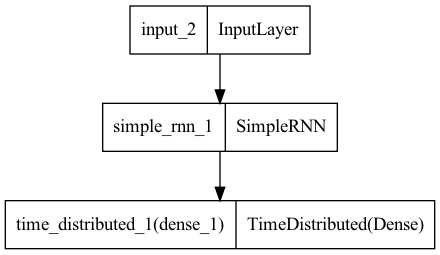

In [165]:
model.summary(expand_nested=True)
plot_model(model)

In [166]:
for l in model.layers:
    print('~'*50)
    print(l.name)
    for w in l.get_weights():
        print(w.shape)
    print('\n')

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
input_2


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
simple_rnn_1
(28, 50)
(50, 50)
(50,)


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
time_distributed_1
(50, 11)
(11,)




In [168]:
rnn_in_w, rnn_h_w, rnn_b = model.layers[1].get_weights()
head_w, head_b = model.layers[-1].get_weights()

rnn_in_w.shape, rnn_h_w.shape, rnn_b.shape, head_w.shape, head_b.shape


((28, 50), (50, 50), (50,), (50, 11), (11,))

## Feedforward NN mechanics

## Sliding inference

In [171]:
activations = np.zeros((N_CLASSES, emg_test.shape[-1]))
print(emg_test.shape, activations.shape)

rnn_hidden = np.zeros(N_HIDDEN)

alpha=0.5

prev_activations = np.zeros(N_CLASSES);

for i, input_vector in tqdm(enumerate(emg_test.T), total=len(emg_test.T)):
    
    # first layer == Input layer
    output = input_vector
    
    # second layer == SimpleRNN
    rnn_hidden = keras.activations.relu(np.dot(output, rnn_in_w) + np.dot(rnn_hidden, rnn_h_w) + rnn_b)
    
    # third layer, Head == Dense
    output = np.dot(rnn_hidden, head_w) + head_b
    manual_activations = keras.activations.sigmoid(tf.convert_to_tensor([output])).numpy()[0]
    
    activations[:, i] = manual_activations.copy()
    
    activations[:, i] = manual_activations[:]*alpha + prev_activations*(1-alpha)
    prev_activations[:] = activations[:, i]    
    
#     if i>10000:
#         break


(28, 280000) (11, 280000)


  0%|          | 0/280000 [00:00<?, ?it/s]

KeyboardInterrupt: 

([<matplotlib.axis.YTick at 0x7fa8b83ee220>,
 [Text(0, 0, '0'),
  Text(0, 1, '1'),
  Text(0, 2, '2'),
  Text(0, 3, '3'),
  Text(0, 4, '4'),
  Text(0, 5, '5'),
  Text(0, 6, '6'),
  Text(0, 7, '7'),
  Text(0, 8, '8'),
  Text(0, 9, '9'),
  Text(0, 10, 'NOGO')])

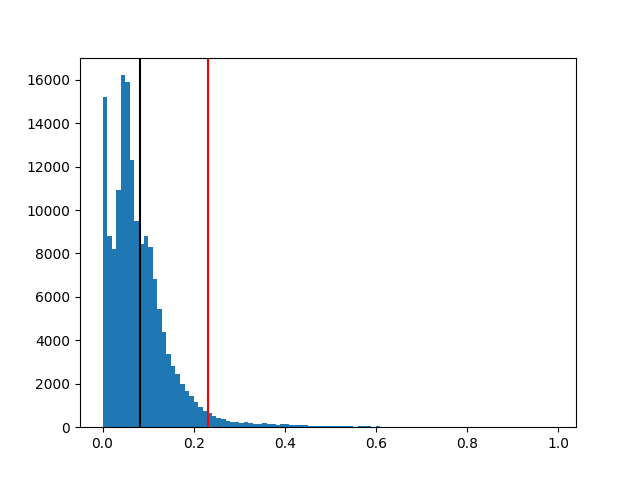

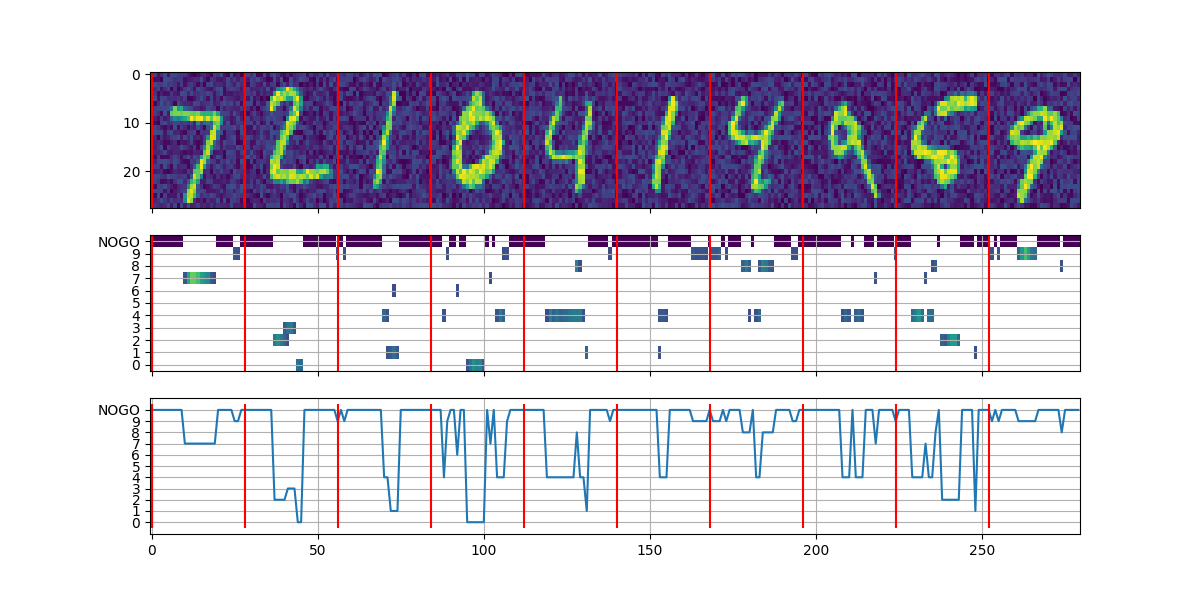

In [172]:
filtered_activations = activations.copy()

activation_thresh = (filtered_activations[filtered_activations>0].mean(-1) + 2*filtered_activations[filtered_activations>0].std(-1)).mean()

plt.figure()
plt.hist(filtered_activations[filtered_activations>0], bins = np.arange(0, 1, 0.01))
plt.axvline(filtered_activations[filtered_activations>0].mean(-1), color='k')
plt.axvline(activation_thresh, color='r')

filtered_activations[filtered_activations<activation_thresh] = np.nan 
filtered_activations[-1, np.isnan(filtered_activations).all(0)] = 0

labels_predicted = np.nanargmax(filtered_activations, axis=0)

start_idx = 0
end_idx = start_idx+10

fig, axx = plt.subplots(3,1, sharex=True, figsize=(12,6))
plt.sca(axx[0])
plt.imshow(emg_test[:, start_idx*28:end_idx*28], aspect='auto')
plt.vlines(np.arange(end_idx-start_idx)*28, *plt.ylim(), color='r')

plt.sca(axx[1])
plt.imshow(filtered_activations[:, start_idx*28:end_idx*28], vmin=0, vmax=1, aspect='auto', interpolation='nearest')
plt.vlines(np.arange(end_idx-start_idx)*28, *plt.ylim(), color='r')
plt.grid(True)
plt.gca().invert_yaxis()
plt.yticks(np.arange(11), list(range(10))+['NOGO'])

plt.sca(axx[2])
plt.plot(labels_predicted[start_idx*28:end_idx*28])
plt.vlines(np.arange(end_idx-start_idx)*28, *plt.ylim(), color='r')
plt.grid(True)
plt.yticks(np.arange(11), list(range(10))+['NOGO'])


Text(0.5, 1.0, 'Manual calculation')

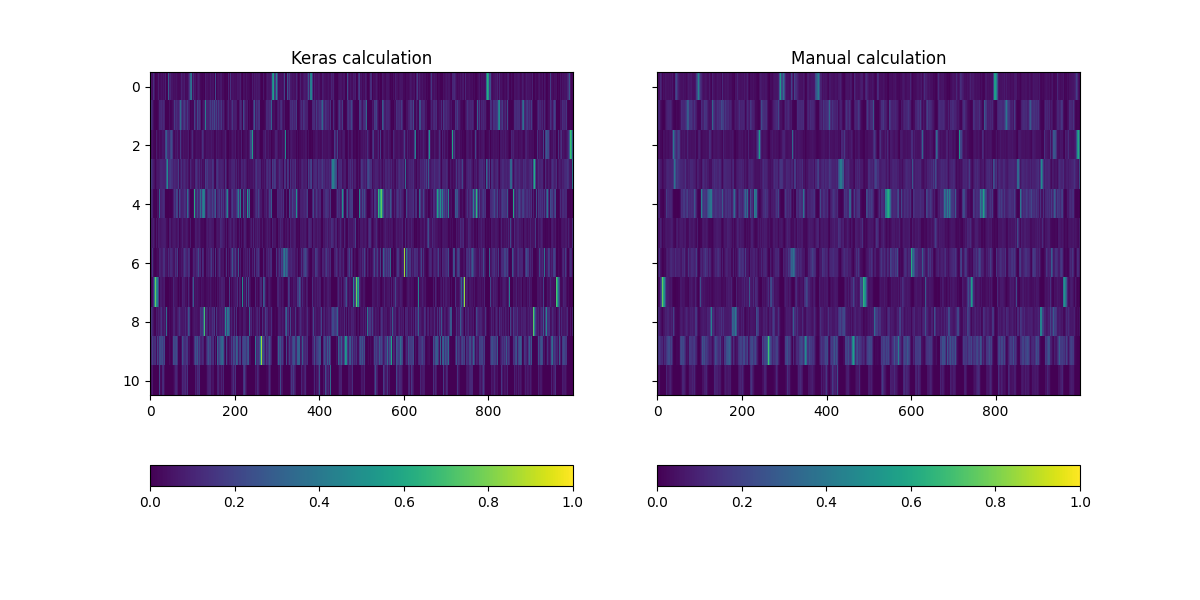

In [173]:
fig, axx = plt.subplots(1,2, sharex=True, sharey=True, figsize=(12,6))
plt.sca(axx[0])
plt.imshow(activations_keras[:, :1000], 
           aspect='auto', 
           interpolation="nearest", vmin=0, vmax=1)
plt.title('Keras calculation')
plt.colorbar(orientation='horizontal')

plt.sca(axx[1])
plt.imshow(activations[:, :1000], 
           aspect='auto', 
           interpolation="nearest", vmin=0, vmax=1)
plt.colorbar(orientation='horizontal')

plt.title('Manual calculation')

### Check coincidence

In [71]:
np.abs(activations - activations_keras).max()

0.45456440428573264

## Numpy pseudocode

### DOT product (Скалярное умножение)

In [174]:
x = emg_test[:,0].copy()
print(x.shape, rnn_in_w.shape)

np.dot(x, rnn_in_w)

(28,) (28, 50)


array([-9.83137218e-01, -2.03149435e+00, -1.47706842e+00,  3.07168903e-01,
        5.34141937e-01,  3.03785322e-02,  1.61355374e-01, -2.41025055e+00,
        3.72279973e-01, -1.20139006e+00, -5.06137252e-01,  2.89707926e-01,
       -2.94297430e-01, -1.03793258e+00, -2.39256012e-01, -8.16308466e-01,
        6.92770201e-01,  2.70047657e-01, -5.89635345e-01,  1.94649547e-01,
       -3.82417922e-01,  1.53088196e-03, -5.04640582e-02, -2.51277745e-01,
       -2.13214536e+00, -1.38737719e+00,  6.77083944e-01, -6.96014727e-01,
       -7.67009035e-01,  2.05501904e-01, -1.73167351e-03, -1.44174426e-01,
        5.11669497e-01, -3.02210791e+00,  5.27265449e-01,  2.94009035e-01,
       -1.80589832e+00, -1.79893311e-01,  2.42838839e-02, -2.51925680e-01,
       -3.71752842e-03,  6.52576670e-01,  2.66835324e-01, -6.25910639e-01,
        1.78173885e-01, -5.66073501e-01,  1.53446814e-01,  3.65788561e-01,
        4.43226936e-01,  1.46331388e-01])

In [175]:
np.sum([x[i] * rnn_in_w[i, 0] for i in range(N_CHANNELS)])

-0.9831372183747441

In [178]:
np.array([np.sum([x[i] * rnn_in_w[i, k] 
                  for i in range(N_CHANNELS)]) 
          for k in range(N_HIDDEN)])

array([-9.83137218e-01, -2.03149435e+00, -1.47706842e+00,  3.07168903e-01,
        5.34141937e-01,  3.03785322e-02,  1.61355374e-01, -2.41025055e+00,
        3.72279973e-01, -1.20139006e+00, -5.06137252e-01,  2.89707926e-01,
       -2.94297430e-01, -1.03793258e+00, -2.39256012e-01, -8.16308466e-01,
        6.92770201e-01,  2.70047657e-01, -5.89635345e-01,  1.94649547e-01,
       -3.82417922e-01,  1.53088196e-03, -5.04640582e-02, -2.51277745e-01,
       -2.13214536e+00, -1.38737719e+00,  6.77083944e-01, -6.96014727e-01,
       -7.67009035e-01,  2.05501904e-01, -1.73167351e-03, -1.44174426e-01,
        5.11669497e-01, -3.02210791e+00,  5.27265449e-01,  2.94009035e-01,
       -1.80589832e+00, -1.79893311e-01,  2.42838839e-02, -2.51925680e-01,
       -3.71752842e-03,  6.52576670e-01,  2.66835324e-01, -6.25910639e-01,
        1.78173885e-01, -5.66073501e-01,  1.53446814e-01,  3.65788561e-01,
        4.43226936e-01,  1.46331388e-01])

In [179]:
from numba import njit

@njit
def manual_relu(x):
    return max(x, 0)

@njit
def manual_sigmoid(x):
    return 1/(1+np.exp(-x))
        
@njit
def manual_dot(x, y, shape):
    s = 0.0
    for i in range(shape):
        s = s + x[i]*y[i]
    return s

rnn_hidden = np.zeros(N_HIDDEN)

def model_call(x, y):   
    """assume x is input data, y are activations for classes"""
    # first layer == Input layer
    x = x
    # y = np.zeros(N_CLASSES)
    
    # second layer == SimpleRNN
    rnn_hidden_prev = np.zeros(N_HIDDEN)
    for hi in range(N_HIDDEN):
        rnn_hidden_prev[hi] = manual_dot(x, rnn_in_w[:, hi], N_CHANNELS) + manual_dot(rnn_hidden, rnn_h_w[:, hi], N_HIDDEN) + rnn_b[hi]

    for hi in range(N_HIDDEN):
        rnn_hidden[hi] = manual_relu(rnn_hidden_prev[hi])
        
    for ci in range(N_CLASSES):
        y[ci] = manual_dot(rnn_hidden, head_w[:, ci], N_HIDDEN) + head_b[ci]

        
    for ci in range(N_CLASSES):
        y[ci] = manual_sigmoid(y[ci])
    
prev_x = np.zeros(N_CLASSES)

def postprocess(x, alpha):
    """assume x is an activation vec"""
    for ci in range(N_CLASSES):
        x[ci] = x[ci]*alpha + prev_x[ci]*(1-alpha) 
        prev_x[ci] = x[ci]    

In [180]:
%%time

activations = np.zeros((N_CLASSES, emg_test.shape[-1]))
print(emg_test.shape, activations.shape)

act = np.zeros(N_CLASSES)

for i in tqdm(range(emg_test.shape[-1]), total = emg_test.shape[-1]):
    model_call(emg_test[:, i], act)   
    postprocess(act, 0.5)
    activations[:, i] = act[:]

    # break
    if (i>10000):
        break

(28, 280000) (11, 280000)


  0%|          | 0/280000 [00:00<?, ?it/s]

CPU times: user 4 s, sys: 97.2 ms, total: 4.1 s
Wall time: 4.03 s


In [79]:
np.abs(activations[:, :10000] - activations_keras[:, :10000]).max()

0.4151164085998069

Text(0.5, 1.0, 'Manual calculation')

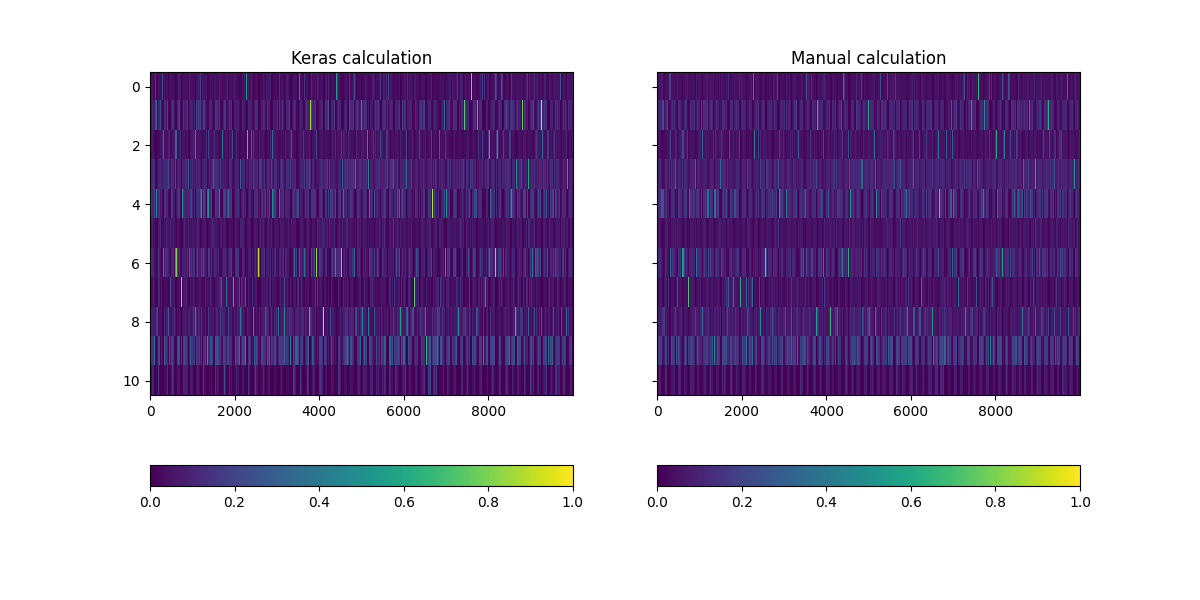

In [181]:
fig, axx = plt.subplots(1,2, sharex=True, sharey=True, figsize=(12,6))
plt.sca(axx[0])
plt.imshow(activations_keras[:, :10000], 
           aspect='auto', 
           interpolation="nearest", vmin=0, vmax=1)
plt.title('Keras calculation')
plt.colorbar(orientation='horizontal')

plt.sca(axx[1])
plt.imshow(activations[:, :10000], 
           aspect='auto', 
           interpolation="nearest", vmin=0, vmax=1)
plt.colorbar(orientation='horizontal')

plt.title('Manual calculation')

([<matplotlib.axis.YTick at 0x7fa8bc8e6a60>,
 [Text(0, 0, '0'),
  Text(0, 1, '1'),
  Text(0, 2, '2'),
  Text(0, 3, '3'),
  Text(0, 4, '4'),
  Text(0, 5, '5'),
  Text(0, 6, '6'),
  Text(0, 7, '7'),
  Text(0, 8, '8'),
  Text(0, 9, '9'),
  Text(0, 10, 'NOGO')])

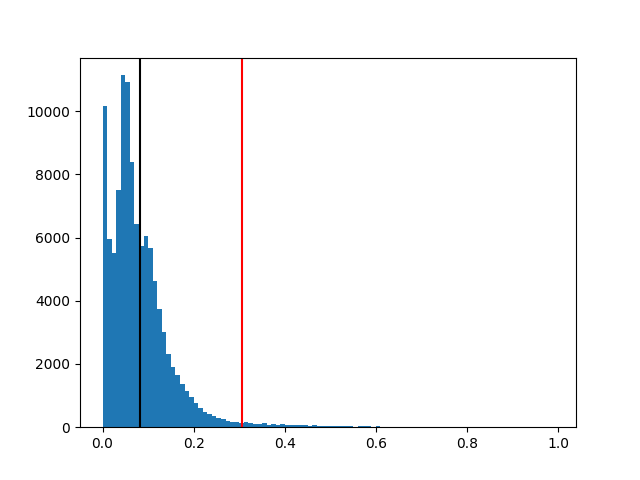

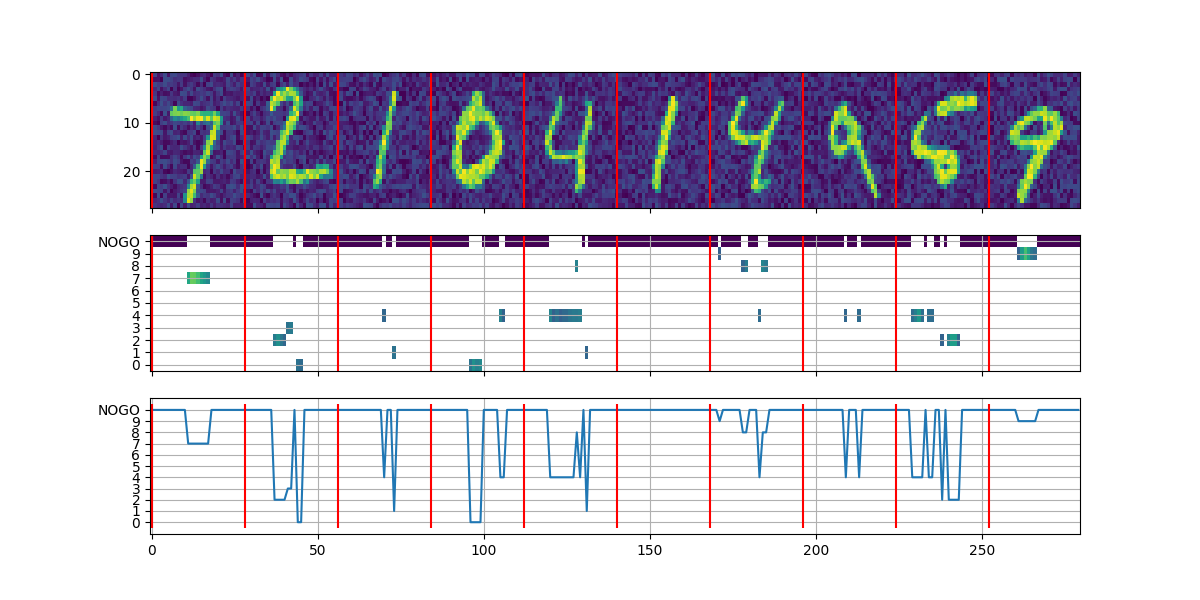

In [182]:
filtered_activations = activations.copy()

activation_thresh = (filtered_activations[filtered_activations>0].mean(-1) + 3*filtered_activations[filtered_activations>0].std(-1)).mean()

plt.figure()
plt.hist(filtered_activations[filtered_activations>0], bins = np.arange(0, 1, 0.01))
plt.axvline(filtered_activations[filtered_activations>0].mean(-1), color='k')
plt.axvline(activation_thresh, color='r')

filtered_activations[filtered_activations<activation_thresh] = np.nan 
filtered_activations[-1, np.isnan(filtered_activations).all(0)] = 0

labels_predicted = np.nanargmax(filtered_activations, axis=0)

start_idx = 0
end_idx = start_idx+10

fig, axx = plt.subplots(3,1, sharex=True, figsize=(12,6))
plt.sca(axx[0])
plt.imshow(emg_test[:, start_idx*28:end_idx*28], aspect='auto')
plt.vlines(np.arange(end_idx-start_idx)*28, *plt.ylim(), color='r')

plt.sca(axx[1])
plt.imshow(filtered_activations[:, start_idx*28:end_idx*28], vmin=0, vmax=1, aspect='auto', interpolation='nearest')
plt.vlines(np.arange(end_idx-start_idx)*28, *plt.ylim(), color='r')
plt.grid(True)
plt.gca().invert_yaxis()
plt.yticks(np.arange(11), list(range(10))+['NOGO'])

plt.sca(axx[2])
plt.plot(labels_predicted[start_idx*28:end_idx*28])
plt.vlines(np.arange(end_idx-start_idx)*28, *plt.ylim(), color='r')
plt.grid(True)
plt.yticks(np.arange(11), list(range(10))+['NOGO'])


# Porting

Jinja - template rendering engine

https://jinja.palletsprojects.com/en/3.1.x/

`%conda install -c conda-forge jinja`

In [67]:
# rnn_in_w, rnn_h_w, rnn_b = model.layers[1].get_weights()
# head_w, head_b = model.layers[-1].get_weights()

In [183]:
rnn_in_w.shape, rnn_h_w.shape, rnn_b.shape, head_w.shape, head_b.shape

((28, 50), (50, 50), (50,), (50, 11), (11,))

In [82]:
import os
import jinja2

template_dir = './'
render_dir = './mnist_rnn_port/'

render_dict = {}
render_dict['N_CHANNELS'] = N_CHANNELS
render_dict['N_CLASSES'] = N_CLASSES
render_dict['N_HIDDEN'] = N_HIDDEN
render_dict['ACTIVATION_THRESH'] = activation_thresh
render_dict['ALPHA_ACTIVATIONS'] = alpha

render_dict['rnn_in_w'] = rnn_in_w
render_dict['rnn_h_w'] = rnn_h_w
render_dict['rnn_b'] = rnn_b
render_dict['head_w'] = head_w
render_dict['head_b'] = head_b

# print(render_dict)

render_filenames = ['w.cpp.jinja', 'w.h.jinja']
for filename in render_filenames:
    filename_out = os.path.join(render_dir, filename.replace('.jinja', ''))
    print(filename, '>', filename_out)
    with open(os.path.join(template_dir, filename), 'r') as f:
        render = jinja2.Template(f.read()).render(render_dict)

        print('~'*100)
        # print(render)
        
        with open(filename_out, 'w+') as f_out:
            f_out.write(render)

w.cpp.jinja > ./mnist_rnn_port/w.cpp
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
w.h.jinja > ./mnist_rnn_port/w.h
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


### Export toy data

In [83]:
emg_test.shape

(28, 280000)

In [84]:
DATA_LEN = 28*10

render_dict = {}
render_dict['DATA_LEN'] = DATA_LEN
render_dict['DATA'] = (emg_test[:, :DATA_LEN]*100).astype(int)

render_filenames = ['data.cpp.jinja', 'data.h.jinja']
for filename in render_filenames:
    filename_out = os.path.join(render_dir, filename.replace('.jinja', ''))
    print(filename, '>', filename_out)
    with open(os.path.join(template_dir, filename), 'r') as f:
        render = jinja2.Template(f.read()).render(render_dict)

        print('~'*100)
        print(render)

        with open(filename_out, 'w+') as f_out:
            f_out.write(render)

data.cpp.jinja > ./mnist_rnn_port/data.cpp
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#include "data.h"
#include <avr/pgmspace.h>

const byte data[N_CHANNELS][DATA_LEN] PROGMEM = { {
27, 8, 11, 1, 12, 5, 7, 32, 21, 15, 27, 9, 7, 21, 0, 10, 9, 26, 14, 20, 29, 10, 8, 22, 5, 32, 12, 32, 30, 25, 22, 4, 27, 20, 24, 11, 24, 26, 17, 21, 16, 12, 25, 13, 25, 29, 26, 8, 20, 23, 30, 7, 28, 24, 5, 19, 10, 14, 23, 4, 32, 11, 29, 2, 23, 13, 11, 27, 19, 20, 4, 5, 1, 14, 27, 27, 27, 6, 16, 23, 3, 8, 23, 32, 7, 15, 31, 13, 1, 26, 22, 17, 1, 27, 20, 17, 5, 21, 32, 1, 21, 9, 8, 29, 15, 26, 15, 32, 19, 21, 23, 10, 0, 27, 25, 8, 30, 26, 8, 28, 14, 2, 32, 18, 20, 7, 6, 25, 19, 22, 15, 4, 32, 20, 7, 17, 14, 32, 12, 2, 0, 20, 6, 11, 10, 4, 10, 22, 17, 28, 26, 18, 30, 25, 4, 7, 15, 13, 30, 28, 19, 26, 23, 10, 31, 14, 19, 23, 5, 5, 0, 24, 24, 6, 27, 30, 10, 28, 11, 20, 11, 20, 22, 15, 26, 30, 24, 6, 13, 0, 30, 5, 4, 20, 25, 22, 3, 32, 32, 20, 3, 14, 28, 

In [85]:
render_dict['DATA'].max()

132

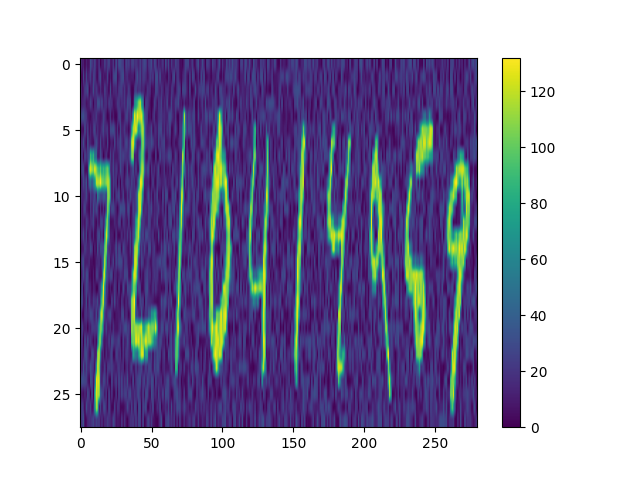

In [86]:
plt.figure()
plt.imshow(render_dict['DATA'], aspect='auto')
plt.colorbar()

In [87]:
emg_test[:, :DATA_LEN]

array([[0.2726499 , 0.08698762, 0.11028756, ..., 0.30676573, 0.2144296 ,
        0.31424156],
       [0.10786249, 0.00216891, 0.2664883 , ..., 0.10223651, 0.22228545,
        0.29853409],
       [0.25514172, 0.04513212, 0.10284862, ..., 0.1974076 , 0.20478661,
        0.13893443],
       ...,
       [0.10055491, 0.09782698, 0.06892224, ..., 0.3192864 , 0.12623212,
        0.10737273],
       [0.11911871, 0.26859403, 0.17615352, ..., 0.17860573, 0.3269347 ,
        0.01663536],
       [0.19243757, 0.23551348, 0.32965886, ..., 0.06419848, 0.1050268 ,
        0.20888102]])

In [88]:
emg_test[:, :DATA_LEN][0]

array([2.72649904e-01, 8.69876233e-02, 1.10287559e-01, 1.73955226e-02,
       1.22822267e-01, 5.91764744e-02, 7.41556794e-02, 3.28685917e-01,
       2.11095832e-01, 1.50026154e-01, 2.71250072e-01, 9.75262894e-02,
       7.57985122e-02, 2.13238910e-01, 9.65936506e-03, 1.01905240e-01,
       9.67953185e-02, 2.62759014e-01, 1.49341433e-01, 2.04729733e-01,
       2.96537332e-01, 1.00116522e-01, 8.02646472e-02, 2.28828793e-01,
       5.63452085e-02, 3.24108931e-01, 1.26712223e-01, 3.22299050e-01,
       3.02877878e-01, 2.54102264e-01, 2.26684929e-01, 4.55260746e-02,
       2.72233863e-01, 2.01278280e-01, 2.42677271e-01, 1.13759163e-01,
       2.49767299e-01, 2.69920584e-01, 1.71253600e-01, 2.13680430e-01,
       1.68970259e-01, 1.25368035e-01, 2.51446506e-01, 1.38685618e-01,
       2.51903830e-01, 2.94394689e-01, 2.65580628e-01, 8.40312790e-02,
       2.00728569e-01, 2.38732477e-01, 3.07115489e-01, 7.74635180e-02,
       2.89017697e-01, 2.43171632e-01, 5.79497500e-02, 1.96041671e-01,
      

In [89]:
from sklearn.decomposition import PCA

In [90]:
pca = PCA()
X = np.random.randn(100, 10)
pca.fit(X)

PCA()

In [95]:
%pip install micromlgen

  Created wheel for micromlgen: filename=micromlgen-1.1.28-py3-none-any.whl size=32171 sha256=bc4e85c642e39fa744b6b84b7366c941dd62a0cf7356c66830d3beb51606ebe2
  Stored in directory: /Users/mike/Library/Caches/pip/wheels/b5/c1/36/9848f822936171a90ec43d0534cb86a58e1dff20c645e22074
Successfully built micromlgen
Note: you may need to restart the kernel to use updated packages.


In [92]:
from micromlgen import port

ModuleNotFoundError: No module named 'micromlgen'

In [91]:
port(pca)

NameError: name 'port' is not defined

In [80]:
print(port(pca))

#pragma once
#include <cstdarg>
namespace Eloquent {
    namespace ML {
        namespace Port {
            class PCA {
                public:
                    /**
                    * Apply dimensionality reduction
                    * @warn Will override the source vector if no dest provided!
                    */
                    void transform(float *x, float *dest = NULL) {
                        static float u[10] = { 0 };
                        u[0] = dot(x,   -0.253377169934  , 0.253096499887  , 0.669616928556  , -0.051557474012  , 0.255729184836  , 0.351623261555  , 0.454245289134  , -0.023163089055  , -0.057220022911  , 0.146667620509 );
                        u[1] = dot(x,   0.618145805127  , -0.377757486769  , -0.121603575779  , 0.204236191197  , 0.222406305185  , 0.548602750085  , 0.236573251477  , -0.055889022395  , 0.060666937553  , -0.074126162179 );
                        u[2] = dot(x,   0.246599430228  , 0.364788901646  , 0.17974801013  , 0.355852587986